# PF

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from da.l63 import gen_l63
from da.scheme import rk4
from da.loss import loss_rms
from da.visualize import plot_loss
from da.pf import ParticleFilter as PF

In [3]:
# params
s = 10
b = 8/3
r = 28

# time step size
dt = 0.01

# obs_per
obs_per = 12

# Dt: 時間刻み
# NOTE: nature runの生成に使ったdtに対して，Dt = dt * obs_perとなるように設定．
Dt = dt * obs_per

lorenz = gen_l63(s, r, b)
# モデルの遷移関数(非線形)
# 0.01ずつ時間発展させる
# dtは同化step
def M(x, Dt):
    for i in range(int(Dt/0.01)):
        x = rk4(lorenz, 0, x, 0.01)
    return x

# 単位行列
I = np.eye(3)

# 観測
# H = I
H = np.eye(1,3)
# H = np.eye(2,3)

# モデル誤差共分散, 最初は完全モデルを仮定
Q = np.zeros((3, 3))

# 観測誤差共分散, 後で定数倍の変化をさせる.
r0 = 1
R = r0*I

# 観測値と真値
end_step = -1 # 開発用
x_true = np.load('x_true_l63.npy')[:end_step]
y = np.load('x_obs_l63.npy')[:end_step]
if not np.isclose(r0, 1.0):
    y = x_true + np.random.normal(loc=0, scale=np.sqrt(r0), size=x_true.shape) # R = r0*I

y = y@H.T
R = H@R@H.T


# KFの初期値
seed = 1
np.random.seed(seed)
x_0 = x_true[np.random.randint(len(x_true)-1)]

P_0 = 64*I


# params
h = 0.4  # additive inflation
m = 80

In [4]:
end = 100
pf = PF(M, H, R, x_0, P_0, m=80, seed=seed, N_thr=.9, add_inflation=h)
for y_obs in tqdm(y[:end]):
    pf.forecast(Dt)
    pf.update(y_obs)

    if False:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(*y_obs, marker='*')
        for x in pf.X:
            ax.scatter(*x)

        ax.set_xlim([-20, 20])
        ax.set_ylim([-20, 20])
        ax.set_zlim([-20, 20])
        plt.show()
    

x_assim = pf.x

100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


RMSE time mean: 5.245628191026469


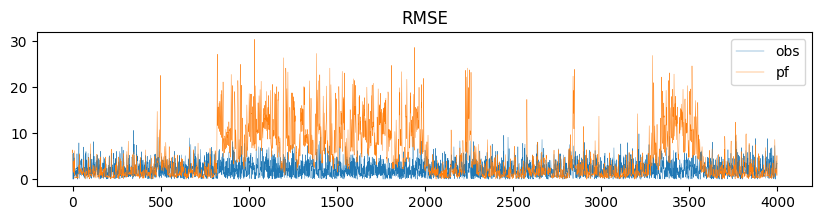

In [ ]:
# plot rmse
fig, ax = plt.subplots(figsize=(10, 2))
plot_loss(x_true[:end]@H.T, y[:end], loss_rms, ax=ax, label='obs', lw=0.3)
plot_loss(x_true[:end], x_assim[:end], loss_rms, ax=ax, label='pf', lw=0.3)
# plt.plot(np.sqrt(pf.trP), lw=0.3, label='trP')
ax.legend()
# ax.set_ylim([0,2])
ax.set_title("RMSE")
print("RMSE time mean:", loss_rms(x_true, x_assim)[200:].mean())

# m vs. h

In [12]:
def compute_rmse(simulate_params):
    m, h = simulate_params.values()
    # RUN DA
    pf = PF(M, H, R, x_0, P_0, m=m, add_inflation=h, seed=seed, N_thr=.9)
    for y_obs in tqdm(y):
        pf.forecast(Dt)
        pf.update(y_obs)

    return loss_rms(x_true, pf.x).mean()

In [13]:
# from da.params import prod_params_kv
from da.optimize import grid_search2

m_list = np.arange(1, 9)*10
h_list = np.arange(0.0, 0.4+1e-6, 0.04)

# params_kv = prod_params_kv("m", m_list, "h", h_list)
# print(params_kv)

df = grid_search2(compute_rmse, "m", m_list, "h", h_list, n_multi=1, multi_type="process")

100%|██████████| 3999/3999 [00:44<00:00, 90.33it/s]


<Axes: >

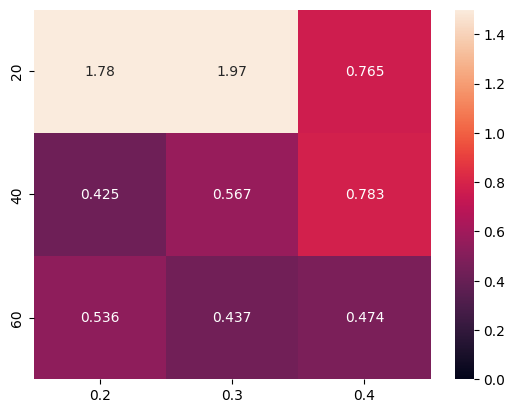

In [14]:
import seaborn as sns
sns.heatmap(df, annot=True, fmt=".3g", vmax=np.sqrt(r0)*1.5, vmin=max([0.0, np.sqrt(r0)-1.0]))